<a href="https://colab.research.google.com/github/Viroslav/CV_final_task/blob/main/Final_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Your task is to find the shaded segmentation mask.
Check out the guidelines_of_first_20_images folder. This folder is to illustrate and guide you for better understanding on the problem. 

You have to write an algorithm that will solve the following problem. Here are the instructions for your algorithm.

Inputs for the algorithm are in the dataset folder:
1. Image raw (the image folder)
2. Human parsing of the image 
3. Pose estimation of the person (both json and image) [*1]

Output:
1. The person's image with gray shaded region. Look at the sample_output.jpg for details.

Note: you don't have to use all the inputs given to you. You may use only those inputs that you find important for your algorithm to work better.



[*1]
body25 + hands labelling, check out the openpose labels for more details if you want.

## Mount Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path = '/content/drive/MyDrive/Final_task/Task'

## imports

In [8]:
import torch
import json
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
from skimage.transform import rescale, ProjectiveTransform, warp
import pickle
import pandas as pd
import random
from skimage import io
from pylab import imshow

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


from matplotlib import cm
from skimage.feature import canny
import imutils
from sklearn.metrics import accuracy_score

import warnings
import os
import torch
warnings.filterwarnings(action='ignore', category=DeprecationWarning)



np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True


%matplotlib inline
from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


## Auxiliary Functions

In [152]:
def show(img, cmap=None, axis_of = "off"):
    """
    function to plot image
    """
    
    plt.figure(figsize=(14,8))
    plt.imshow(img, cmap=cmap)
    plt.axis(axis_of)
    plt.show()

## work with data

In [10]:
%%time
human_parsing = {}
for img in os.listdir(path + '/dataset/human_parsing/'):
    if img[-4:].lower() == '.png' or img[-4:].lower() == '.jpg':
        # print(f' Loading: {img}')
        human_parsing[img]  = cv2.cvtColor(cv2.imread(f'{path}/dataset/human_parsing/{img}'), cv2.COLOR_BGR2RGB)
print(f'All {len(human_parsing)} photos of human_parsing completed')

All 704 photos of human_parsing completed
CPU times: user 4.12 s, sys: 975 ms, total: 5.1 s
Wall time: 23.8 s


In [11]:
%%time
image = {}
for img in os.listdir(path + '/dataset/image/'):
    if img[-4:].lower() == '.png' or img[-4:].lower() == '.jpg':
        # print(f' Loading: {img}')
        image[img]  = cv2.cvtColor(cv2.imread(f'{path}/dataset/image/{img}'), cv2.COLOR_BGR2RGB)
print(f'All {len(image)} photos of image completed')

All 704 photos of image completed
CPU times: user 6.38 s, sys: 1.06 s, total: 7.44 s
Wall time: 26.9 s


In [12]:
%%time
pose_jpg = {}
for img in os.listdir(path + '/dataset/pose_img/'):
    if img[-4:].lower() == '.png' or img[-4:].lower() == '.jpg':
        # print(f' Loading: {img}')
        pose_jpg[img]  = cv2.cvtColor(cv2.imread(f'{path}/dataset/pose_img/{img}'), cv2.COLOR_BGR2RGB)
print(f'All {len(pose_jpg)} photos of pose_jpg completed')

All 704 photos of pose_jpg completed
CPU times: user 6.74 s, sys: 1.01 s, total: 7.75 s
Wall time: 21.8 s


In [13]:
%%time
pose_json = {}
for key_p in os.listdir(path + '/dataset/pose_json/'):
    if key_p[-5:].lower() == '.json':
        # print(f' Loading: {key_p}')
        with open(f'{path}/dataset/pose_json/{key_p}', 'r') as f:
            pose_json[key_p]  = json.load(f)
print(f'All {len(pose_json)} of pose_json completed')

All 704 of pose_json completed
CPU times: user 216 ms, sys: 131 ms, total: 347 ms
Wall time: 11.6 s


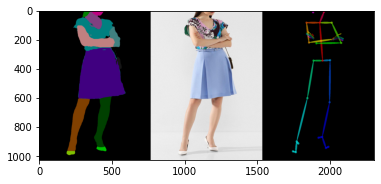

In [14]:
imshow(np.hstack([human_parsing['168762_00.png'], image['168762_00.jpg'], pose_jpg['168762_00_rendered.png']]))

## Thoughts

Use the points of the pelvis, complete the trapezoid to the ankles, subtract the mask of the hands from this

## Json_adjustment

In [15]:
list_of_points_name = ["Nose", "Neck", "LShoulder", "LElbow", "LWrist", "RShoulder", "RElbow", "RWrist", 
                       "MidHip", "LHip", "LKnee", "LAnkle", "RHip", "RKnee", "RAnkle", "LEye", "REye",
                       "LEar", "REar", "RBigToe", "RSmallToe", "RHeel", "LBigToe", "LSmallToe", "LHeel"]

def to_test_json(pose_json):
    right_json = {}
    keypoints = pose_json['people'][0]['pose_keypoints_2d']
    # reshape the data into (x, y) pairs
    keypoints = [keypoints[i:i+3] for i in range(0, len(keypoints), 3)]
    x = [point[0] for point in keypoints]
    y = [point[1] for point in keypoints]
    point_xy = list(zip(x, y)) 
    for i in range(25):
        right_json[list_of_points_name[i]] = (int(point_xy[i][0]), int(point_xy[i][1]))

    return right_json

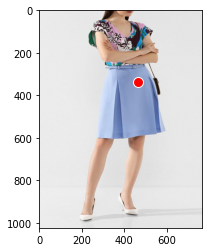

In [16]:
q = to_test_json(pose_json['168762_00_keypoints.json'])
img = image['168762_00.jpg']
# plot the image
fig, ax = plt.subplots()
ax.imshow(img)
# plot the keypoints on top of the image

ax.scatter(q['RHip'][0], 
           q['RHip'][1], c="red", s=100, edgecolors="white") 

plt.axis("on")
plt.show()

## shaded_segmentation_mask_1(draw between key_points)

In [161]:
from scipy.constants import point
def shaded_segmentation_mask(human_parsing, image, pose_json):


#-----------------------------------------------------------------------------#
    # Get the coordinates of the pelvis keypoints
    pelvis_left_point = pose_json["LHip"]
    pelvis_right_point = pose_json["RHip"]
    pelvis_left_x, pelvis_left_y = int(pelvis_left_point[0]), int(pelvis_left_point[1])
    pelvis_right_x, pelvis_right_y = int(pelvis_right_point[0]), int(pelvis_right_point[1])
#-----------------------------------------------------------------------------#
    # Get the coordinates of the right ankles keypoints
    # right 
    ankle_r_r_point = pose_json["RAnkle"]
    ankle_r_r_x, ankle_r_r_y = int(ankle_r_r_point[0]) + 100, int(ankle_r_r_point[1])
    # left
    ankle_r_l_point = pose_json["RHeel"]
    ankle_r_l_x, ankle_r_l_y = int(ankle_r_l_point[0]), int(ankle_r_l_point[1])
#-----------------------------------------------------------------------------#
    # Get the coordinates of the left ankles keypoints
    # right 
    ankle_l_r_point = pose_json["LAnkle"]
    ankle_l_r_x, ankle_l_r_y = int(ankle_l_r_point[0]), int(ankle_l_r_point[1])
    # left
    ankle_l_l_point = pose_json["LHeel"]
    ankle_l_l_x, ankle_l_l_y = int(ankle_l_l_point[0]) - 50, int(ankle_l_l_point[1])
#-----------------------------------------------------------------------------#    
    # Get the coordinates of the knees keypoints
    knee_l_point = pose_json["LKnee"]
    knee_r_point = pose_json["RKnee"]
    knee_l_x, knee_l_y = int(knee_l_point[0]) - 50, int(knee_l_point[1])
    knee_r_x, knee_r_y = int(knee_r_point[0]) + 50, int(knee_r_point[1])
#-----------------------------------------------------------------------------#
    # Create a mask representing the body of the person
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    
    # adjust posture for knee position
    if knee_r_x > ankle_r_r_x or knee_l_x < ankle_l_l_x:
        print('yes')
        # Create additional point
        add_r_x, add_r_y = knee_r_x+10, ankle_r_r_y
        add_l_x, add_l_y = knee_l_x-10, ankle_l_l_y
        if knee_r_x > ankle_r_r_x and knee_l_x < ankle_l_l_x:
            cv2.fillConvexPoly(mask, np.array([[pelvis_right_x, pelvis_right_y], [knee_r_x, knee_r_y],
                                           [add_r_x, add_r_y],
                                           [ankle_r_r_x, ankle_r_r_y], [ankle_r_l_x, ankle_r_l_y],
                                           [ankle_l_r_x, ankle_l_r_y], [ankle_l_l_x, ankle_l_l_y],
                                           [add_l_x, add_l_y], 
                                           [knee_l_x, knee_l_y], [pelvis_left_x, pelvis_left_y]]), 1)
        else:
            if knee_r_x > ankle_r_r_x:
                cv2.fillConvexPoly(mask, np.array([[pelvis_right_x, pelvis_right_y], [knee_r_x, knee_r_y],
                                           [add_r_x, add_r_y],
                                           [ankle_r_r_x, ankle_r_r_y], [ankle_r_l_x, ankle_r_l_y],
                                           [ankle_l_r_x, ankle_l_r_y], [ankle_l_l_x, ankle_l_l_y], 
                                           [knee_l_x, knee_l_y], [pelvis_left_x, pelvis_left_y]]), 1)
            elif knee_l_x < ankle_l_l_x:
                cv2.fillConvexPoly(mask, np.array([[pelvis_right_x, pelvis_right_y], [knee_r_x, knee_r_y],
                                           [ankle_r_r_x, ankle_r_r_y], [ankle_r_l_x, ankle_r_l_y],
                                           [ankle_l_r_x, ankle_l_r_y], [ankle_l_l_x, ankle_l_l_y],
                                           [add_l_x, add_l_y],  
                                           [knee_l_x, knee_l_y], [pelvis_left_x, pelvis_left_y]]), 1)


    else:
        print('no')
        cv2.fillConvexPoly(mask, np.array([[pelvis_right_x, pelvis_right_y], [knee_r_x, knee_r_y], 
                                       [ankle_r_r_x, ankle_r_r_y], [ankle_r_l_x, ankle_r_l_y],
                                       [ankle_l_r_x, ankle_l_r_y], [ankle_l_l_x, ankle_l_l_y], 
                                       [knee_l_x, knee_l_y], [pelvis_left_x, pelvis_left_y]]), 1)

    # Subtract the hands mask from the body mask
    hands_mask = np.logical_and(human_parsing == 17, human_parsing == 18)
    mask = np.logical_xor(mask, hands_mask[:, :, 1])

    # Combine the body mask with the human parsing mask
    final_mask = np.logical_or(mask, human_parsing[:, :, 1])

    return mask

yes


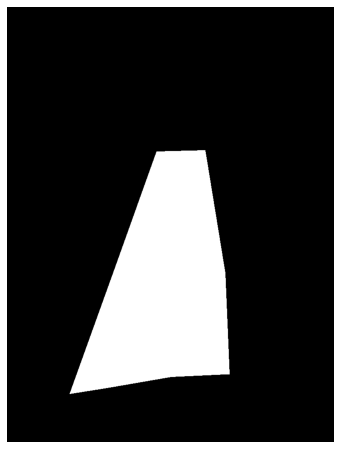

In [18]:
test = shaded_segmentation_mask(human_parsing['168762_00.png'], image['168762_00.jpg'], to_test_json(pose_json['168762_00_keypoints.json']))
show(test, cmap= 'gray')

## segment looping using cycles

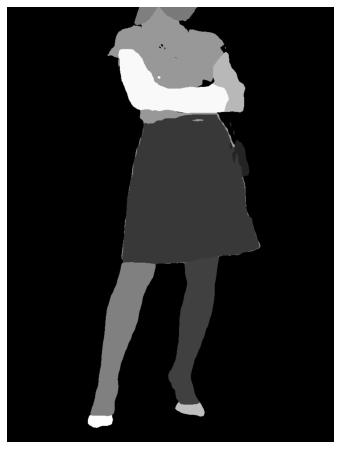

[  0  22  34  38  72  75  76  90 109 113 147 151]


In [19]:
human_parsing_test = cv2.cvtColor(human_parsing['168762_00.png'], cv2.COLOR_RGB2GRAY)
show(human_parsing_test, cmap='gray')
print(np.unique(human_parsing_test))

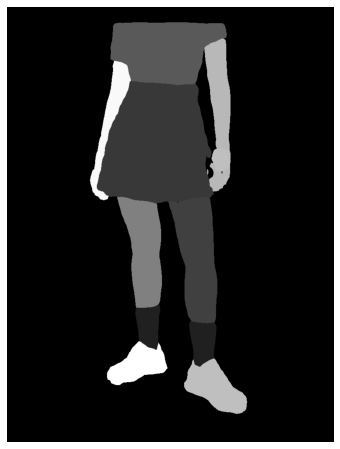

[  0  19  34  38  53  76 109 113 147 151]


In [20]:
human_parsing_test = cv2.cvtColor(human_parsing['48398_00.png'], cv2.COLOR_RGB2GRAY)
show(human_parsing_test, cmap='gray')
print(np.unique(human_parsing_test))

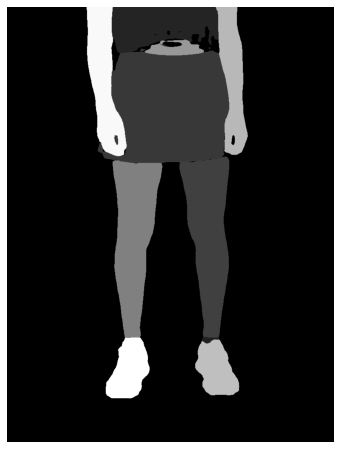

[  0  19  22  34  38  76  90 109 113 147 151]


In [21]:
human_parsing_test = cv2.cvtColor(human_parsing['48365_00.png'], cv2.COLOR_RGB2GRAY)
show(human_parsing_test, cmap='gray')
print(np.unique(human_parsing_test))

In [37]:
np.unique(human_parsing_test)

array([  0,  19,  22,  34,  38,  76,  90, 109, 113, 147, 151], dtype=uint8)

[  0  22  34  38  72  75  76  90 109 113 147 151]
34


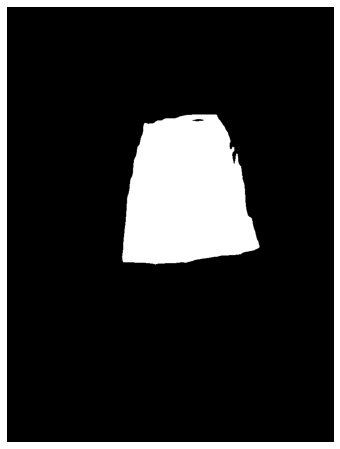

38


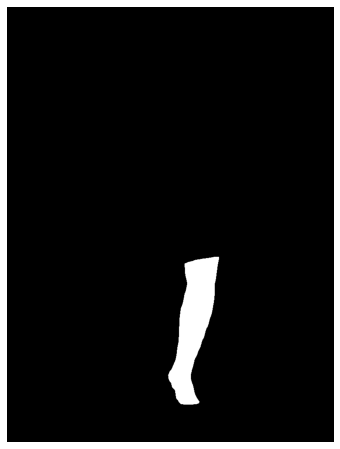

76


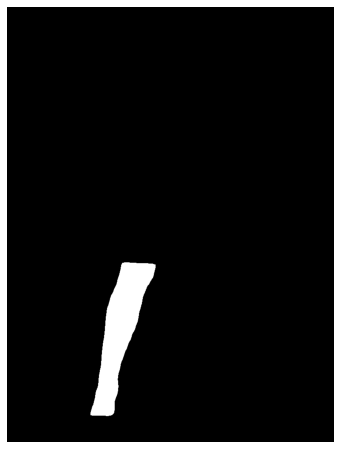

In [98]:
human_parsing_test = cv2.cvtColor(human_parsing['168762_00.png'], cv2.COLOR_RGB2GRAY)
def binary_mask(human_parsing):
    unique_values = np.unique(human_parsing)
    print(unique_values)
    list_of_cont_trash = [19, 22, 53, 72, 75, 90, 109, 113, 147, 151]
    list_of_count_needed = [34, 38, 76]
    #for value in unique_values:
    #for value in list_of_cont_trash:
    for value in list_of_count_needed:
        # Convert the human parsing image to a binary mask with a single value
        binary_mask = np.zeros_like(human_parsing, dtype=np.uint8)
        binary_mask[human_parsing == value] = 255
        print(value)
        show(binary_mask, cmap = 'gray')
        
binary_mask(human_parsing_test)

In [143]:
def shaded_segmentation_mask_2(image, human_parsing, pose_json):
    mask = np.zeros_like(image[:, :, 0])

    pose_json_need = [pose_json["LHip"],   pose_json["RHip"],
                      pose_json["RAnkle"], pose_json["RHeel"],
                      pose_json["LAnkle"], pose_json["LHeel"],
                      pose_json["LKnee"],  pose_json["RKnee"]]             
    print(pose_json_need)
    print(np.unique(human_parsing))
    list_of_count_needed = [34, 38, 76]
    list_of_cont_trash = [19, 22, 53, 72, 75, 90, 109, 113, 147, 151]

    for x, y in pose_json_need:
        # Check if the point falls into the body part or clothes region in the human parsing mask
        #if human_parsing[int(y), int(x)] in np.unique(human_parsing):
        if (human_parsing[int(y), int(x)] in list_of_count_needed) or (human_parsing[int(y)+10, int(x)] in list_of_count_needed):
            if (human_parsing[int(y), int(x)] in list_of_count_needed):
                # If the point falls into a body part or clothes region, include it in the mask
                mask[human_parsing == human_parsing[int(y), int(x)]] = 1
                #show(mask)
            elif (human_parsing[int(y)+10, int(x)] in list_of_count_needed):
                mask[human_parsing == human_parsing[int(y)+10, int(x)]] = 1
                #show(mask)
            
    # Apply morphological operations to fill in the gaps in the mask
    #kernel = np.ones((5, 5), np.uint8)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return mask

[(312, 487), (434, 490), (402, 915), (394, 929), (306, 913), (323, 921), (292, 731), (422, 711)]
[  0  34  38  53  72  75  76  90 109 113 147 151]


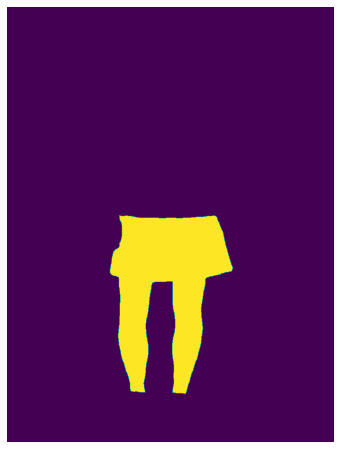

In [144]:
human_parsing_test = cv2.cvtColor(human_parsing['48388_00.png'], cv2.COLOR_RGB2GRAY)
t = shaded_segmentation_mask_2(image['48388_00.jpg'], human_parsing_test, to_test_json(pose_json['48388_00_keypoints.json']))
show(t)

[  0  34  38  53  72  75  76  90 109 113 147 151]
0


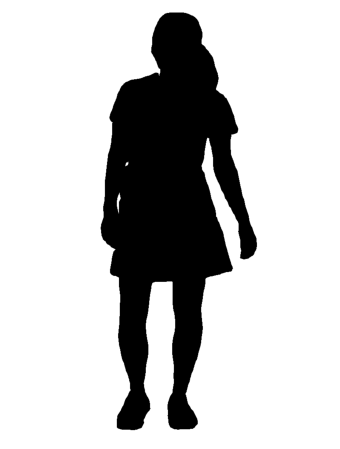

19


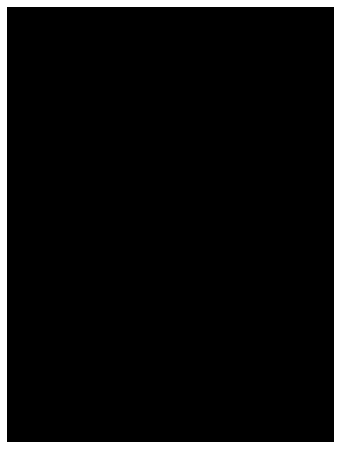

22


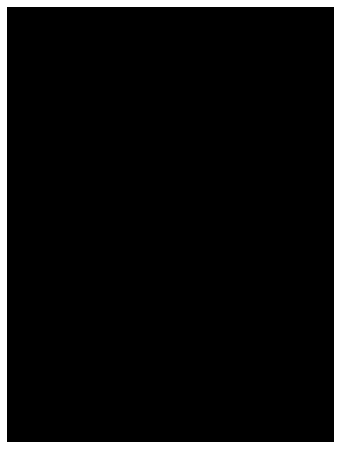

53


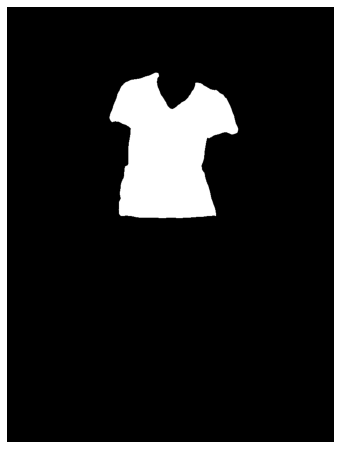

72


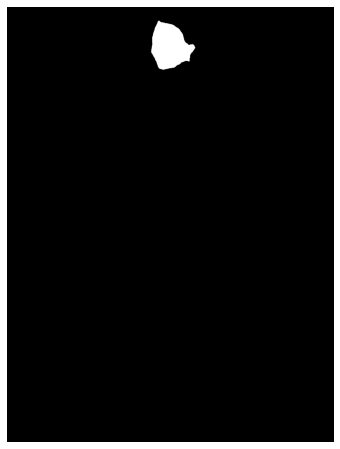

75


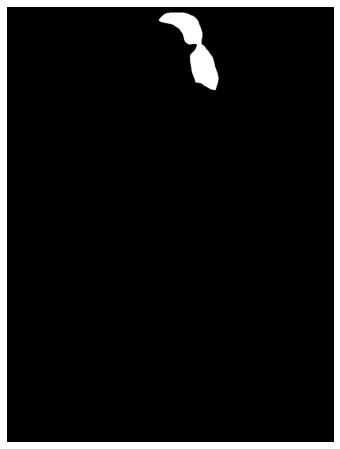

90


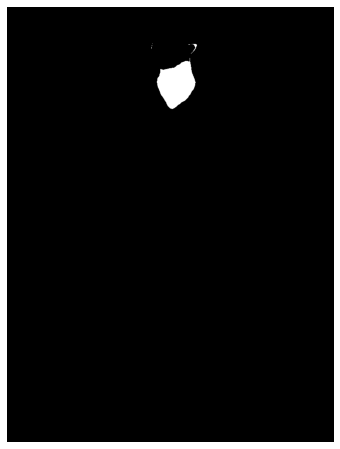

109


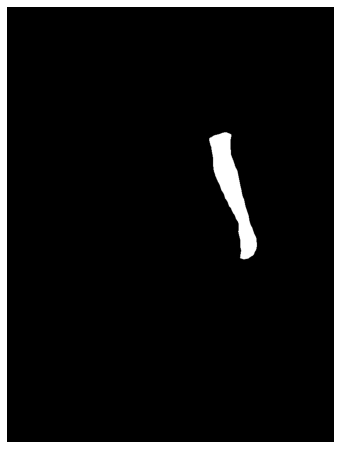

113


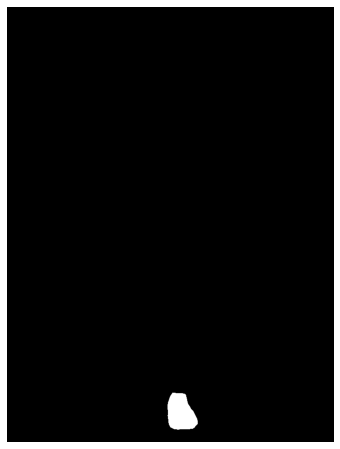

147


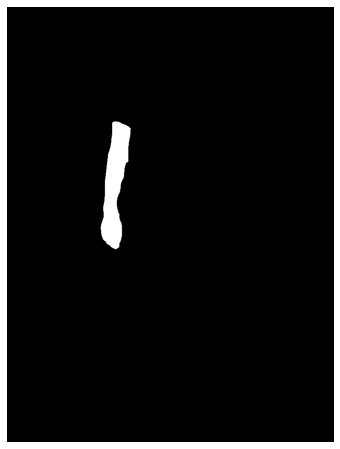

151


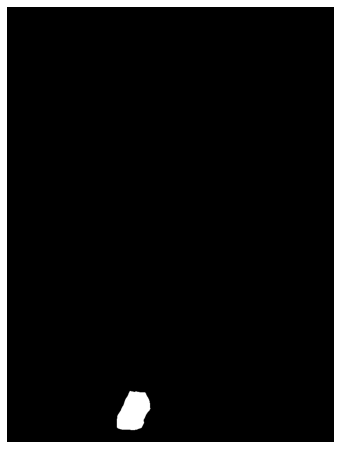

In [128]:
human_parsing_test = cv2.cvtColor(human_parsing['48388_00.png'], cv2.COLOR_RGB2GRAY)
def binary_mask(human_parsing):
    unique_values = np.unique(human_parsing)
    print(unique_values)
    list_of_cont_trash = [0, 19, 22, 53, 72, 75, 90, 109, 113, 147, 151]
    list_of_count_needed = [34, 38, 76]
    #for value in unique_values:
    for value in list_of_cont_trash:
    #for value in list_of_count_needed:
        # Convert the human parsing image to a binary mask with a single value
        binary_mask = np.zeros_like(human_parsing, dtype=np.uint8)
        binary_mask[human_parsing == value] = 255
        print(value)
        show(binary_mask, cmap = 'gray')
        
binary_mask(human_parsing_test)

## plot_with_shade

In [27]:
def plot_with_shade(image, total):
    masked_image = np.copy(image)
    masked_image[:,:,0][total == 1] = 255
    masked_image[:,:,1][total == 1] = 0
    masked_image[:,:,2][total == 1] = 0

    # plot the original image and the masked image side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title('Original image')
    ax[1].imshow(masked_image)
    ax[1].set_title('Masked image')
    plt.show()

## Total Function

In [162]:
def total_func(image, human_parsing, pose_json):
    pose_json = to_test_json(pose_json)
    test = shaded_segmentation_mask(human_parsing, image, pose_json)
    show(test, cmap='gray')
    human_parsing_test = cv2.cvtColor(human_parsing, cv2.COLOR_RGB2GRAY)
    show(human_parsing_test, cmap='gray')
    test_show = shaded_segmentation_mask_2(image, human_parsing_test, pose_json)
    show(test_show, cmap='gray')
    total = test + test_show
    show(total, cmap='gray')

    # set the values of the gray pixels to 1 (white)
    gray_indices = np.where(total == 2)
    total[gray_indices] = 1
    show(total, cmap='gray')
    plot_with_shade(image, total)
    #return total

yes


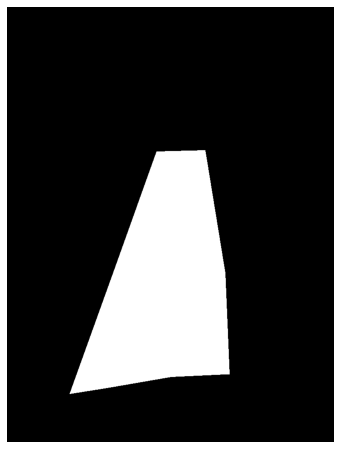

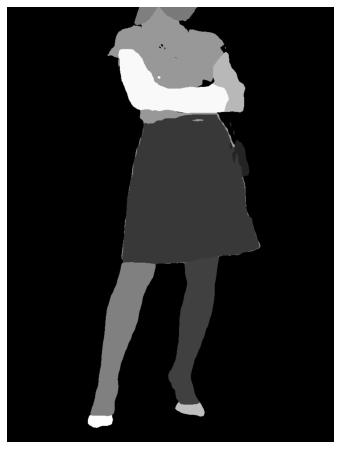

[(351, 340), (465, 337), (411, 864), (385, 870), (235, 896), (247, 910), (309, 598), (462, 626)]
[  0  22  34  38  72  75  76  90 109 113 147 151]


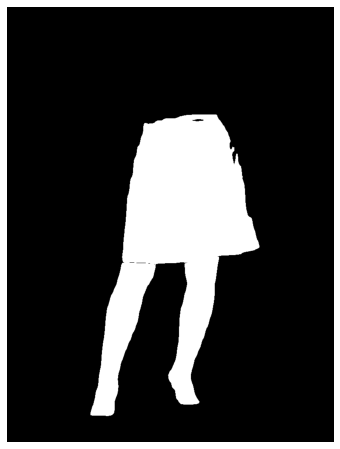

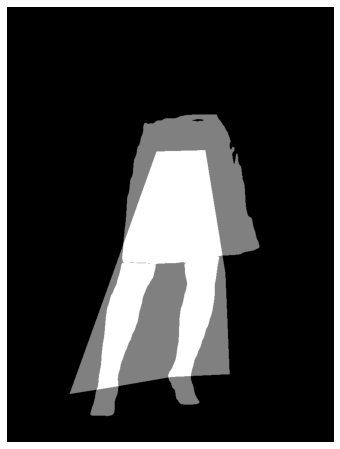

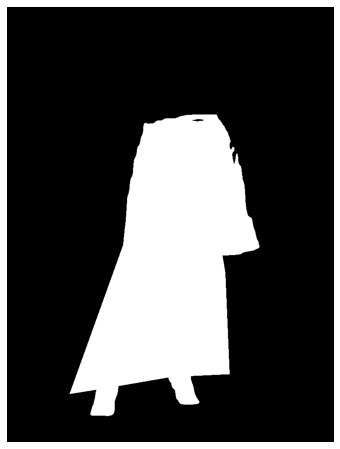

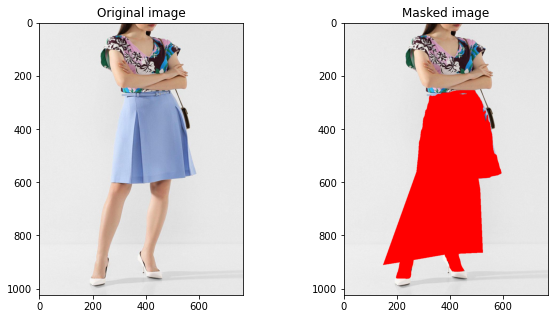

In [138]:
total_func(image['168762_00.jpg'], human_parsing['168762_00.png'], pose_json['168762_00_keypoints.json'])

## plot all together

no


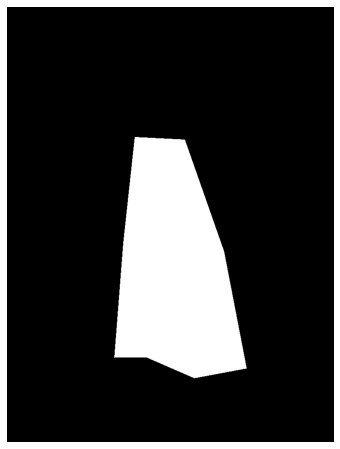

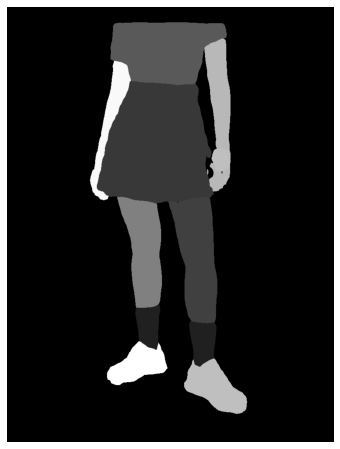

[(300, 306), (417, 312), (462, 850), (439, 873), (329, 805), (352, 825), (323, 555), (459, 575)]
[  0  19  34  38  53  76 109 113 147 151]


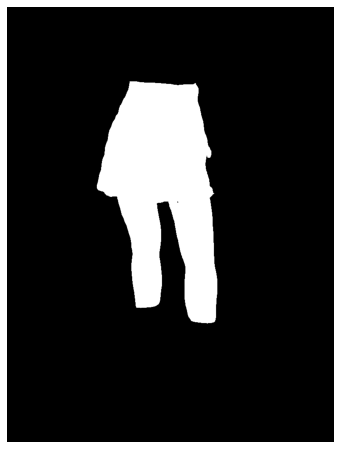

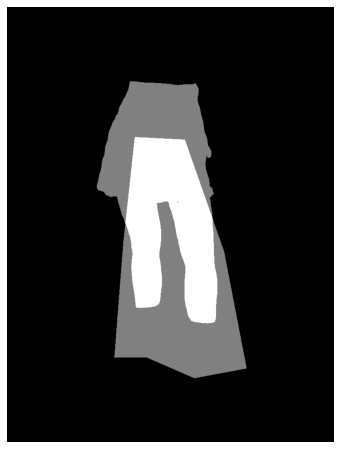

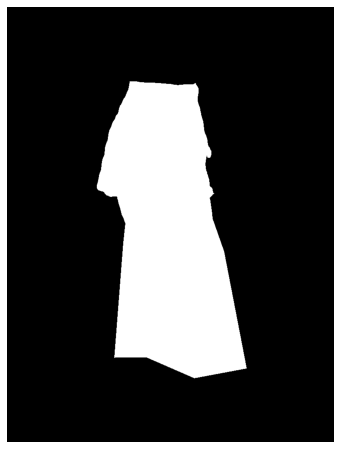

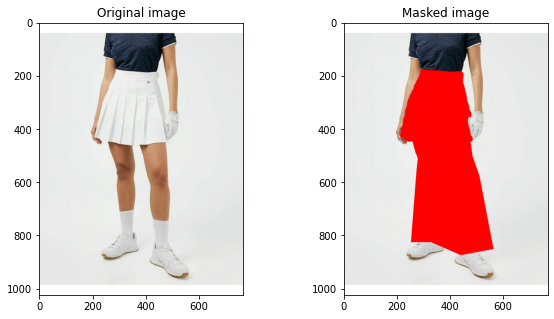

In [145]:
total_func(image['48398_00.jpg'], human_parsing['48398_00.png'], pose_json['48398_00_keypoints.json'])

no


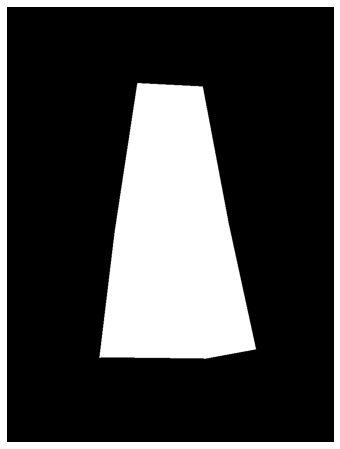

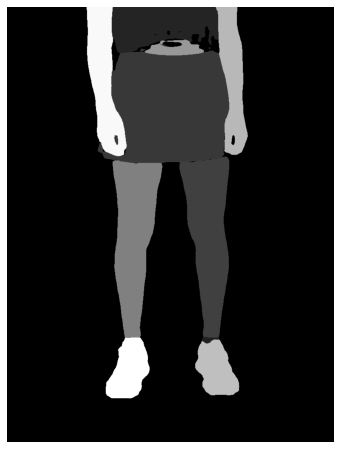

[(306, 179), (459, 187), (484, 805), (465, 827), (300, 805), (317, 825), (303, 527), (470, 510)]
[  0  19  22  34  38  76  90 109 113 147 151]


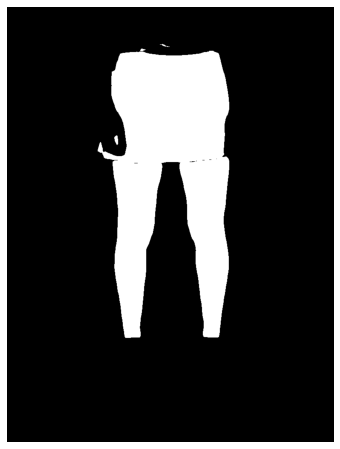

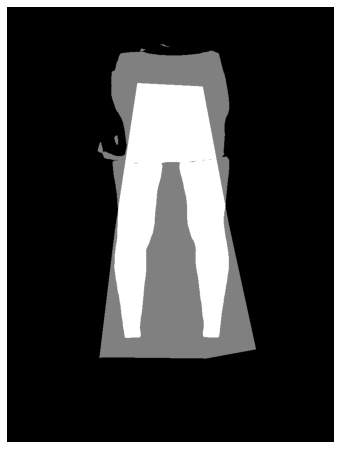

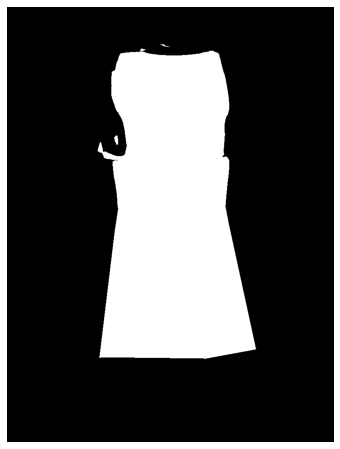

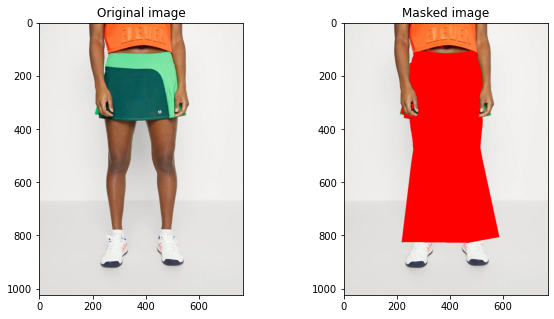

In [136]:
total_func(image['48365_00.jpg'], human_parsing['48365_00.png'], pose_json['48365_00_keypoints.json'])

no


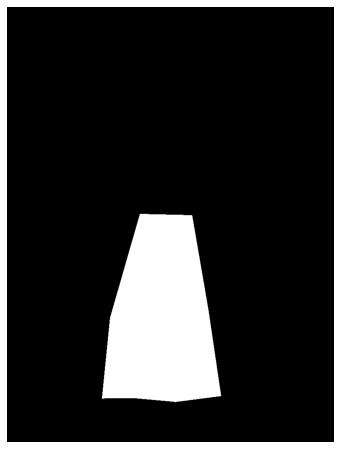

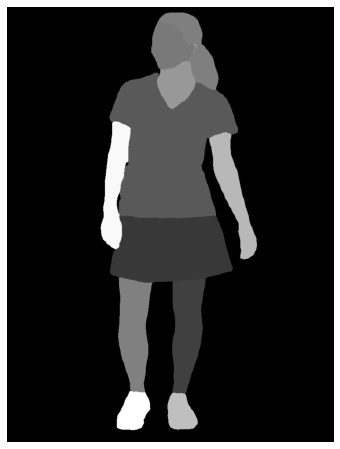

[(312, 487), (434, 490), (402, 915), (394, 929), (306, 913), (323, 921), (292, 731), (422, 711)]
[  0  34  38  53  72  75  76  90 109 113 147 151]


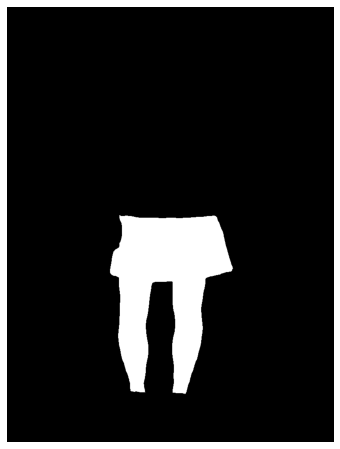

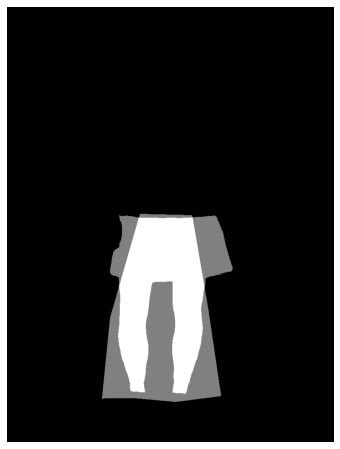

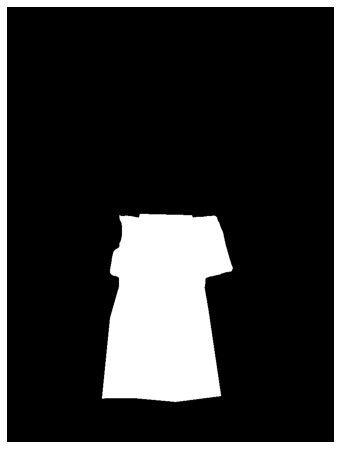

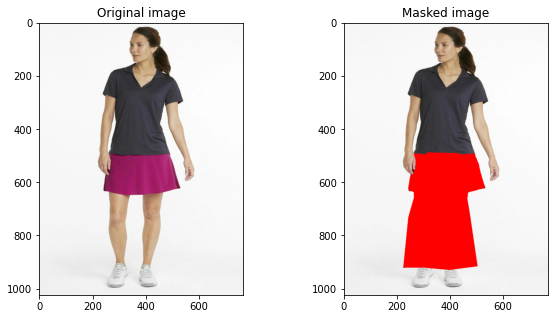

In [135]:
total_func(image['48388_00.jpg'], human_parsing['48388_00.png'], pose_json['48388_00_keypoints.json'])

no


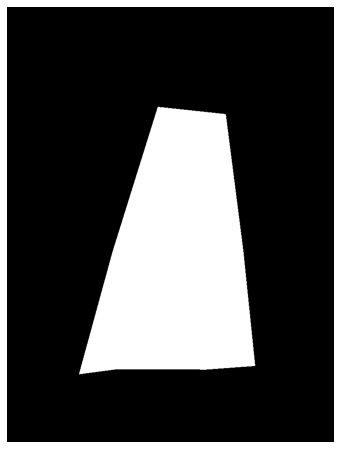

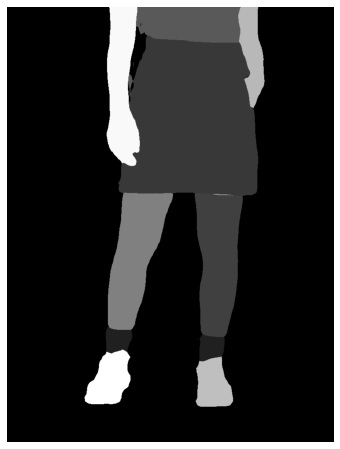

[(354, 235), (513, 252), (482, 844), (462, 853), (252, 842), (269, 864), (298, 575), (504, 572)]
[  0  19  34  38  53  76  90 109 113 147 151]


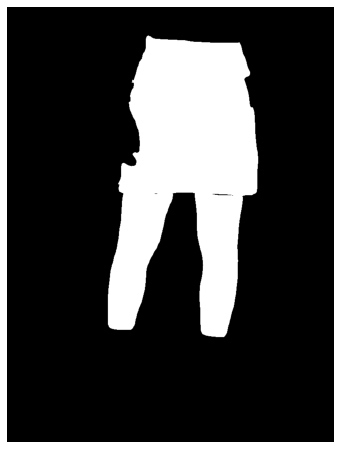

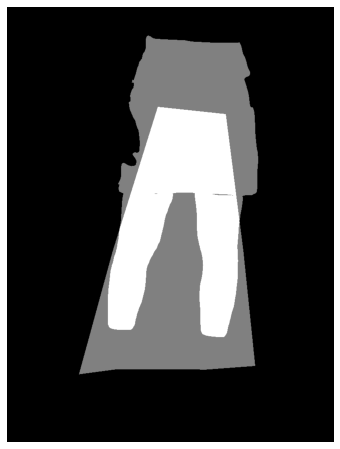

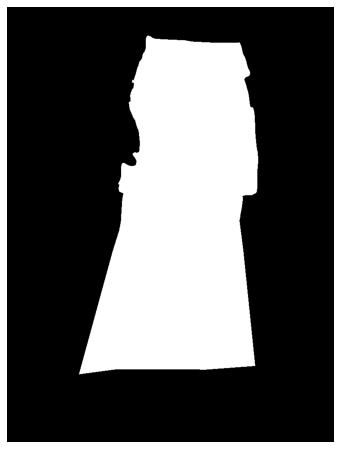

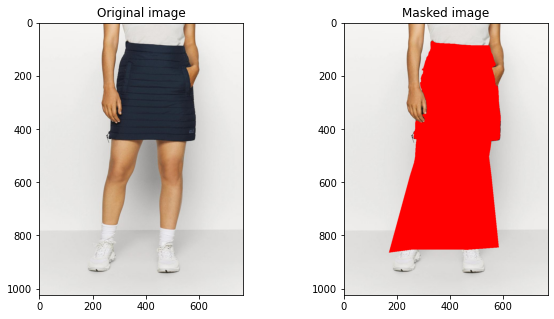

In [147]:
total_func(image['48362_00.jpg'], human_parsing['48362_00.png'], pose_json['48362_00_keypoints.json'])

no


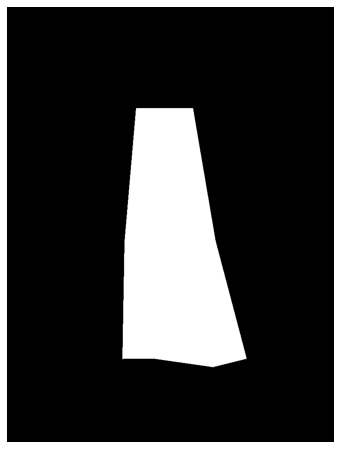

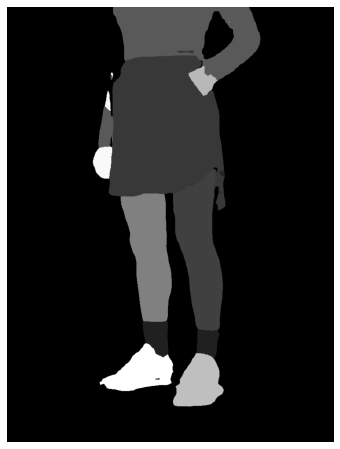

[(303, 238), (436, 238), (462, 827), (482, 847), (349, 808), (371, 828), (326, 552), (439, 550)]
[  0  19  22  34  38  53  76  90 109 113 128 147 151]


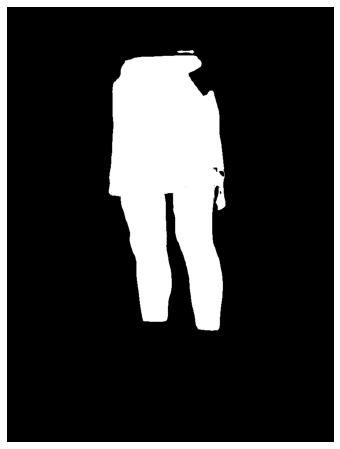

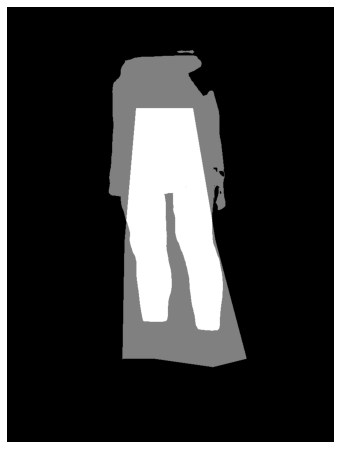

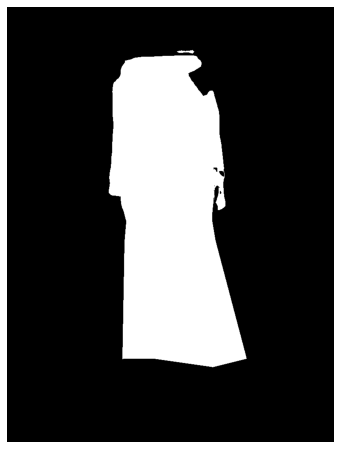

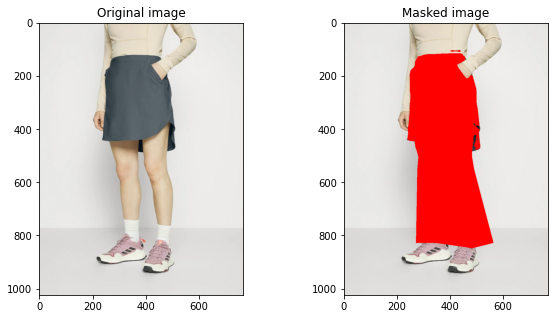

In [155]:
a = total_func(image['48367_00.jpg'], human_parsing['48367_00.png'], pose_json['48367_00_keypoints.json'])

no


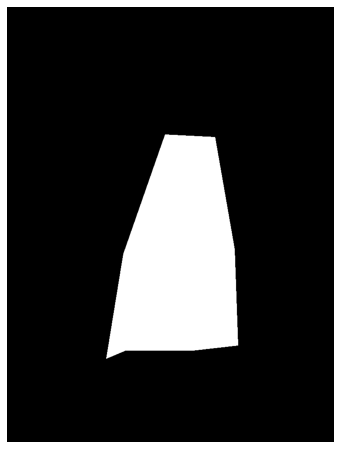

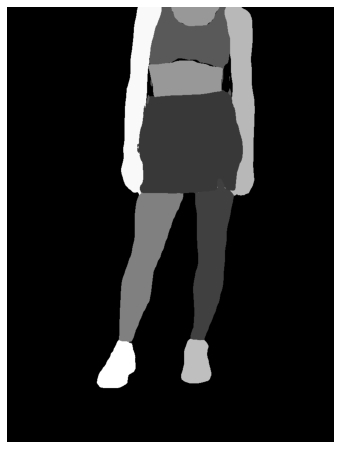

[(371, 300), (488, 306), (442, 796), (436, 808), (278, 808), (283, 827), (323, 581), (484, 570)]
[  0  19  34  38  53  76  90 109 113 147 151]


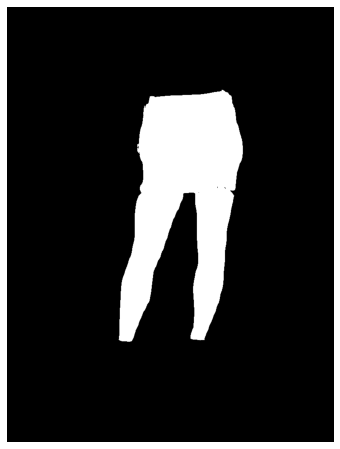

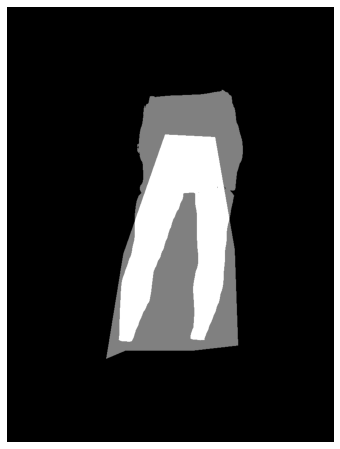

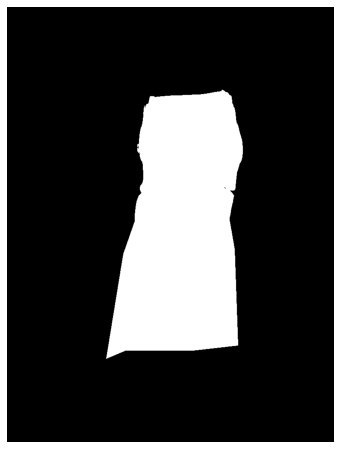

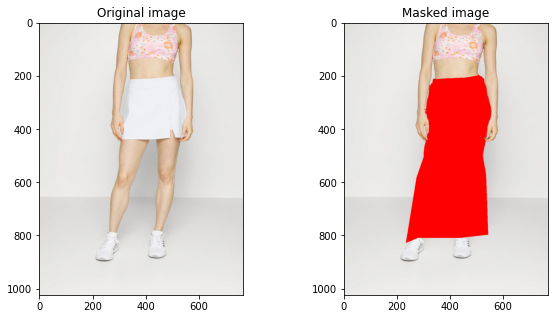

In [164]:
total_func(image['48416_00.jpg'], human_parsing['48416_00.png'], pose_json['48416_00_keypoints.json'])

no


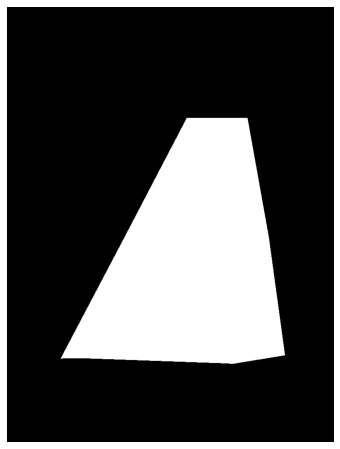

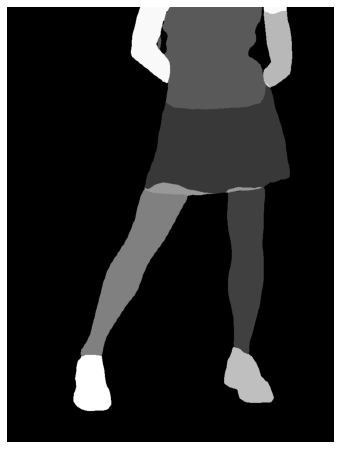

[(422, 261), (564, 261), (552, 819), (530, 839), (196, 819), (176, 827), (323, 547), (564, 541)]
[  0  34  38  53  76  90 109 113 147 151]


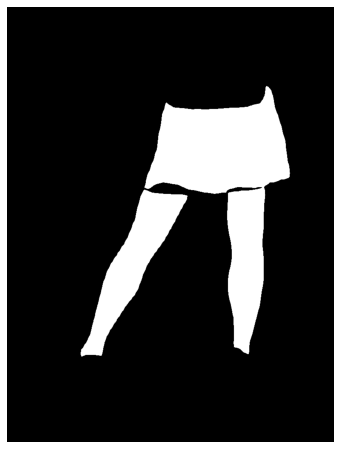

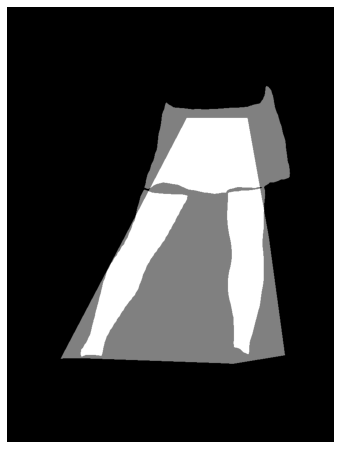

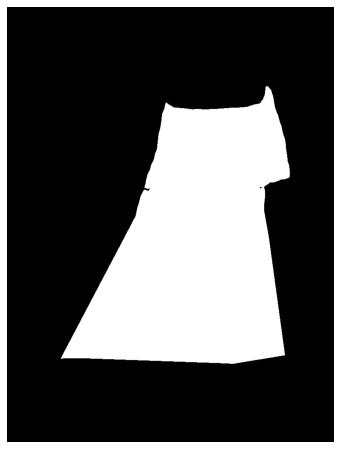

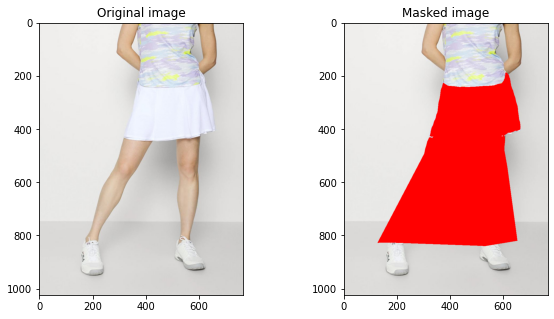

In [163]:
total_func(image['48605_00.jpg'], human_parsing['48605_00.png'], pose_json['48605_00_keypoints.json'])

## shaded_segmentation_mask_2

In [ ]:
def shaded_segmentation_mask_2(image, human_parsing, pose_json):
    # Create a black mask with the same size as the image
    mask = np.zeros_like(image[:, :, 0])

    # Iterate over the key points
    for x, y in pose_json:
        # Check if the point falls into the body part or clothes region in the human parsing mask
        if human_parsing[int(y), int(x)] in np.unique(human_parsing):
            print('g')
            # If the point falls into a body part or clothes region, include it in the mask
            mask[human_parsing == human_parsing[int(y), int(x)]] = 1
            #mask[int(y), int(x)] = 100
            #show(mask)
            #print(mask.sum())
            
    # Apply morphological operations to fill in the gaps in the mask
    #kernel = np.ones((5, 5), np.uint8)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Apply the mask to the image
    #result = cv2.bitwise_and(image, mask)

    return mask
test_show = shaded_segmentation_mask_2(image['168762_00.jpg'], human_parsing_test, pose_json_test[1:7])
show(test_show)

## shit

In [35]:
np.unique(human_parsing['168762_00.png'])

array([  0,  22,  64, 128, 192], dtype=uint8)

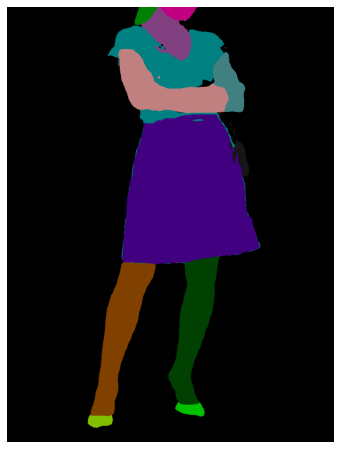

In [ ]:
show(human_parsing['168762_00.png'])

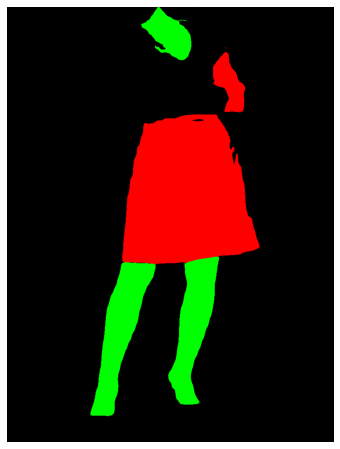

In [ ]:
binary_mask = np.zeros_like(human_parsing['168762_00.png'], dtype=np.uint8)
binary_mask[human_parsing['168762_00.png'] == 64] = 255
show(binary_mask)

0


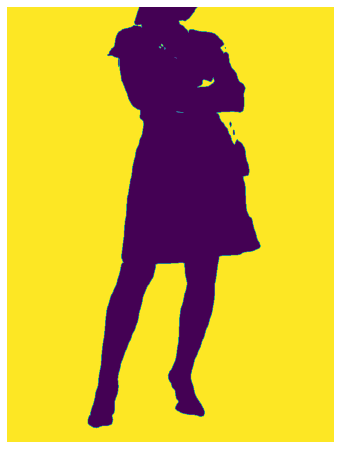

22


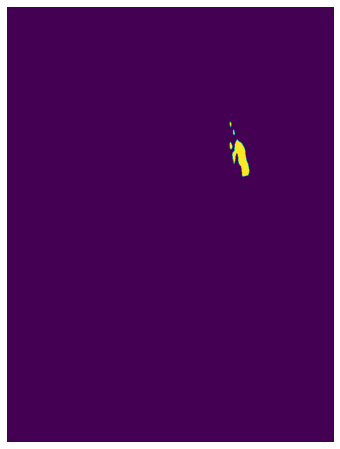

34


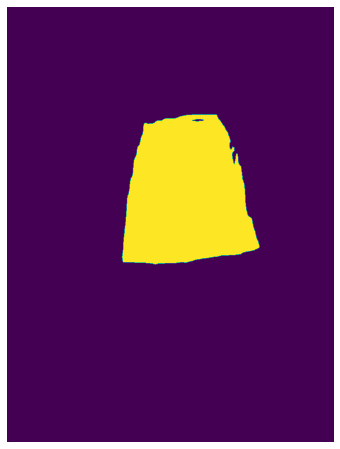

38


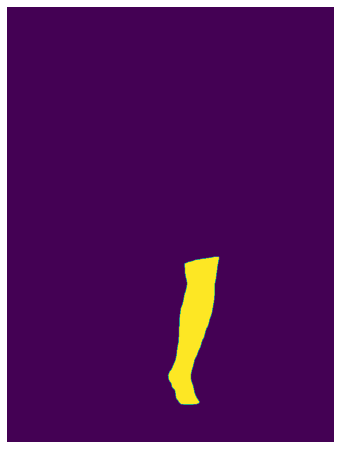

72


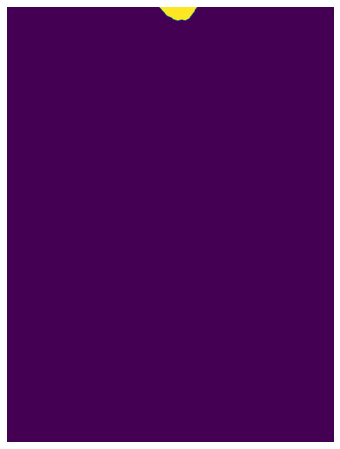

75


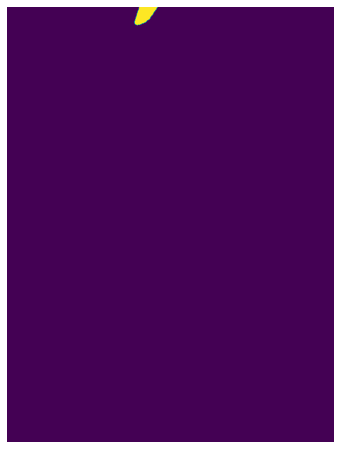

76


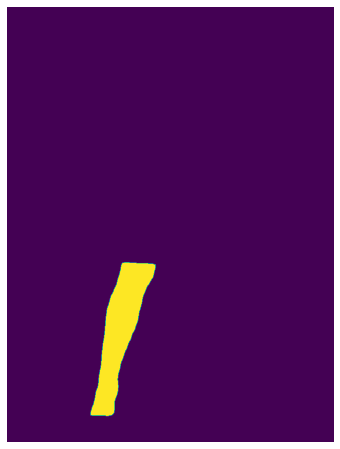

90


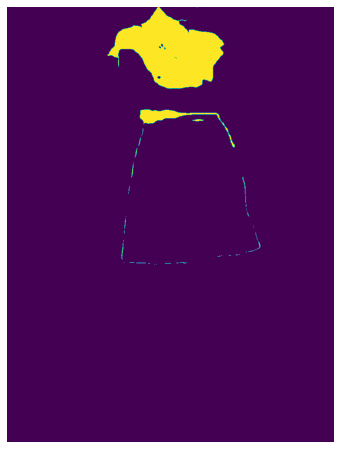

109


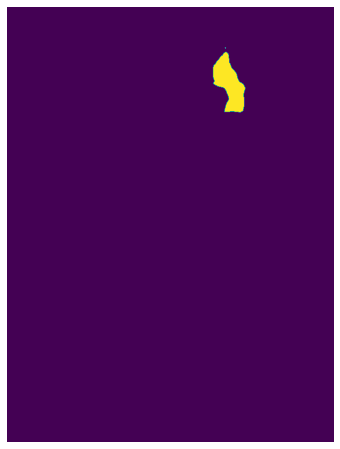

113


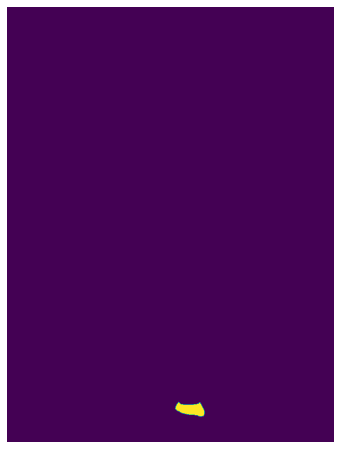

147


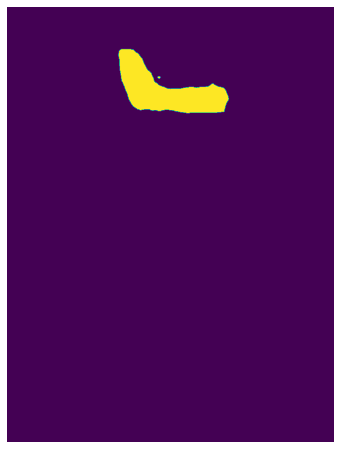

151


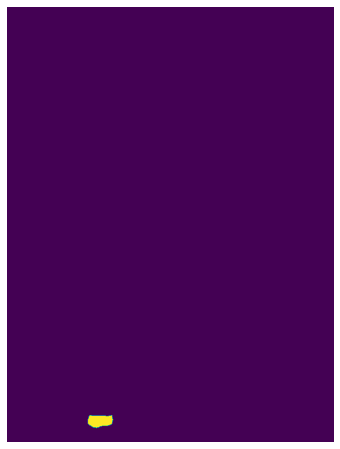

In [114]:
def binary_mask(human_parsing):
    unique_values = np.unique(human_parsing)
    for value in unique_values:
        # Convert the human parsing image to a binary mask with a single value
        binary_mask = np.zeros_like(human_parsing, dtype=np.uint8)
        binary_mask[human_parsing == value] = 255
        print(value)
        show(binary_mask)
        
binary_mask(human_parsing_test)

In [ ]:
binary_mask = np.zeros_like(human_parsing, dtype=np.uint8)
binary_mask[human_parsing == value] = 255
show(binary_mask)

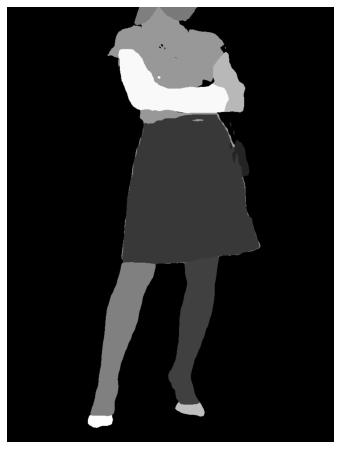

In [ ]:
show(human_parsing_test, cmap = 'gray')

In [ ]:
binary_mask(human_parsing_test, pose_json_test)

In [ ]:
np.unique(human_parsing_test)

array([  0,  22,  34,  38,  72,  75,  76,  90, 109, 113, 147, 151],
      dtype=uint8)

0
22
34


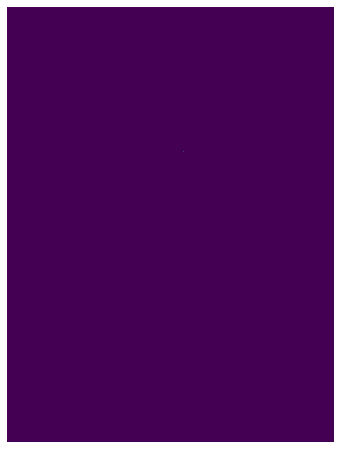

38
72
75
76
90
109
113
147
151
0
22
34


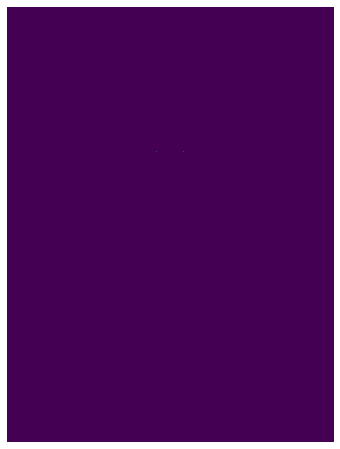

38
72
75
76
90
109
113
147
151
0
22
34


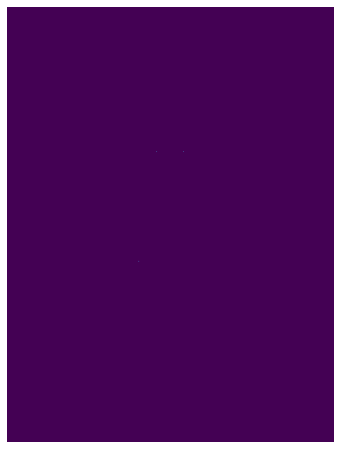

38
72
75
76
90
109
113
147
151
0
22
34
38
72
75
76


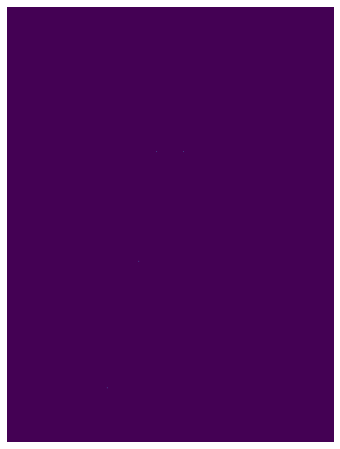

90
109
113
147
151
0
22
34


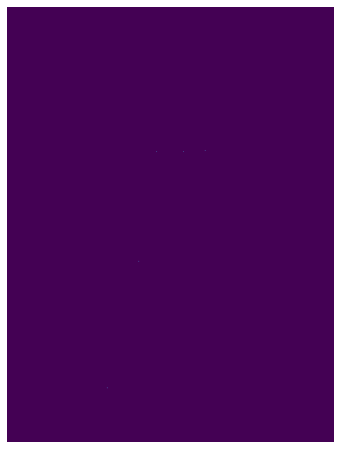

38
72
75
76
90
109
113
147
151
0
22
34
38


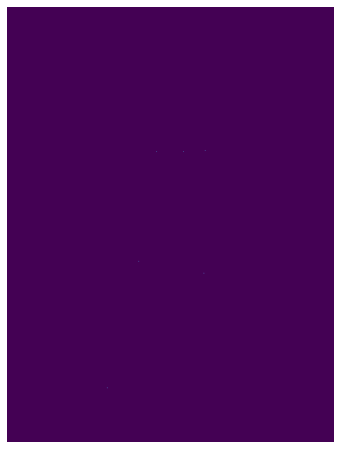

72
75
76
90
109
113
147
151
0
22
34
38


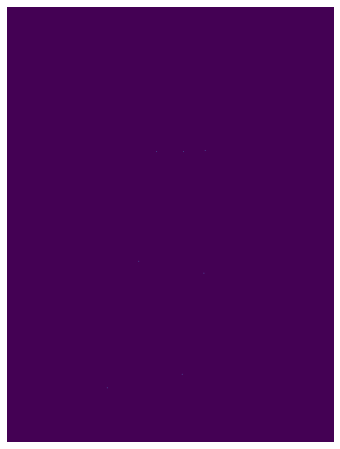

72
75
76
90
109
113
147
151
0
22
34
38
72
75
76
90
109
113


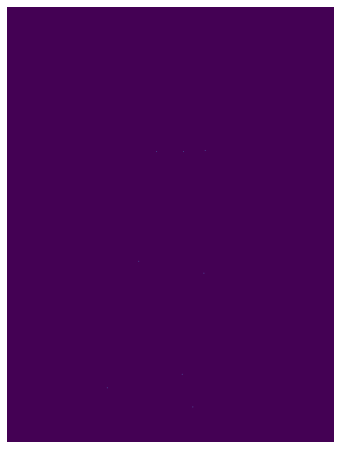

147
151
0
22
34
38
72
75
76
90
109
113


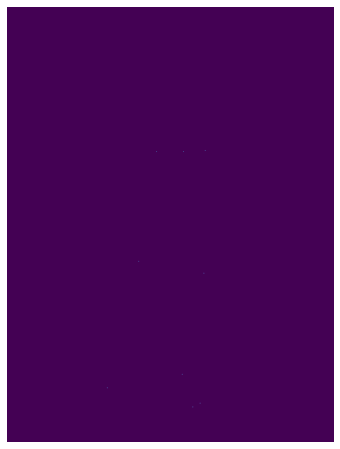

147
151
0
22
34
38


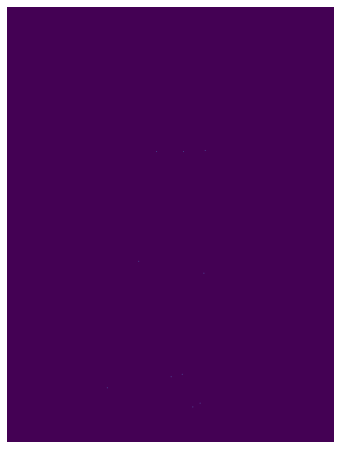

72
75
76
90
109
113
147
151
0
22
34
38
72
75
76
90
109
113
147
151


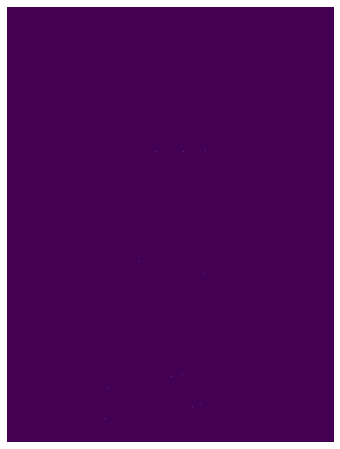

0
22
34
38
72
75
76
90
109
113
147
151


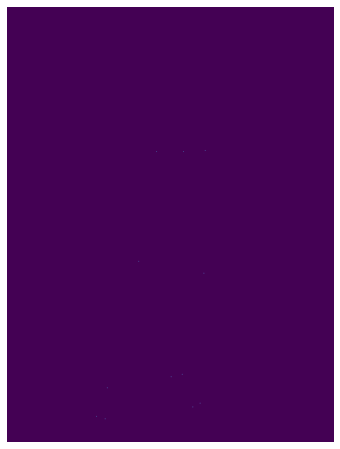

0
22
34
38
72
75
76


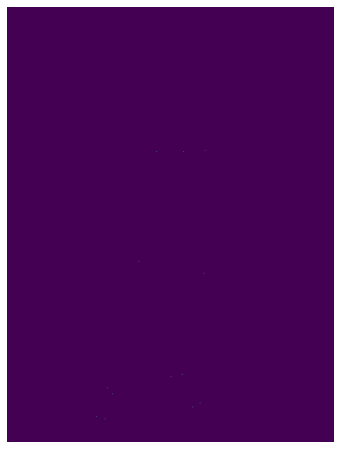

90
109
113
147
151


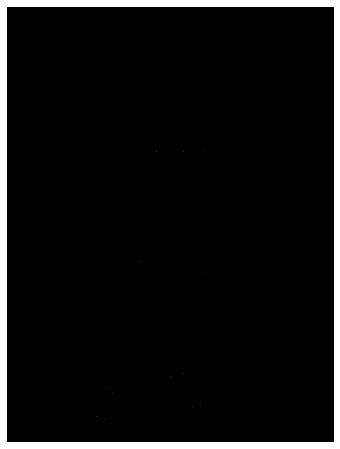

In [ ]:
def shaded_segmentation_mask(human_parsing, pose_json_test):
    mask = np.zeros(human_parsing.shape, dtype=np.uint8)
    for x, y in pose_json_test:
        x, y = int(x), int(y)
        unique_values = np.unique(human_parsing)
        for value in unique_values:
            print(value)
            if human_parsing[y, x] == value:
                mask[y, x] = 255
                show(mask)
    return mask

mask = shaded_segmentation_mask(human_parsing_test, pose_json_test)
show(mask, cmap = 'gray')

In [ ]:
human_parsing['168762_00.png'].shape[1]

768

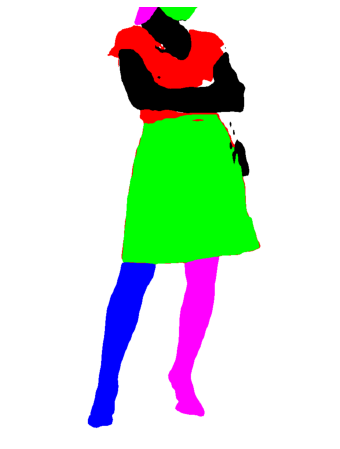

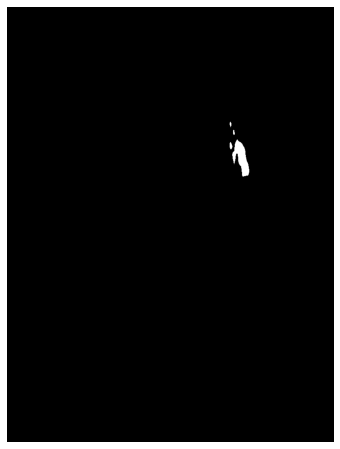

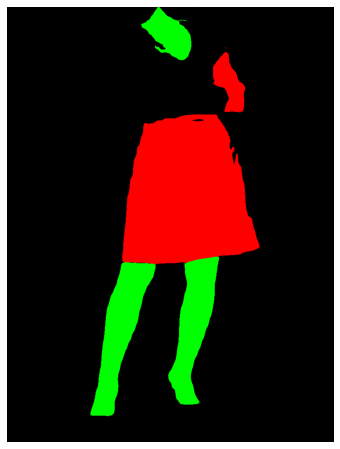

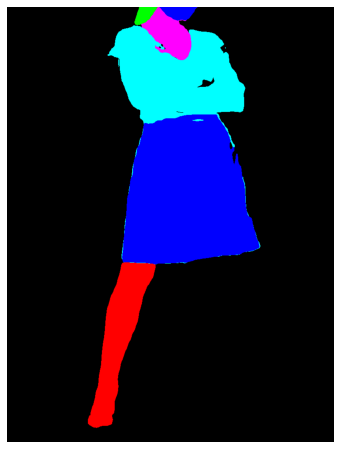

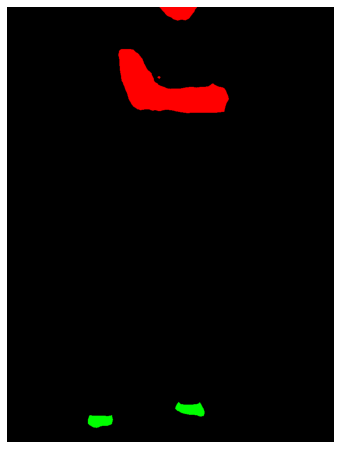

In [ ]:
def binary_mask(human_parsing, key_points):
    unique_values = np.unique(human_parsing)
    for value in unique_values:
        # Convert the human parsing image to a binary mask with a single value
        binary_mask = np.zeros_like(human_parsing, dtype=np.uint8)
        binary_mask[human_parsing == value] = 255
        show(binary_mask)
        
binary_mask(human_parsing['168762_00.png'], pose_json_test)

In [ ]:
def shaded_segmentation_mask(human_parsing, key_points):
    # Initialize a binary mask with the same shape as the human parsing image
    mask = np.zeros_like(human_parsing, dtype=np.uint8)
    
    # Get unique values in the human parsing image
    unique_values = np.unique(human_parsing)
    
    # Iterate over each unique value
    for value in unique_values:
        # Convert the human parsing image to a binary mask with a single value
        binary_mask = np.zeros_like(human_parsing, dtype=np.uint8)
        binary_mask[human_parsing == value] = 255
        
        # Create a convex hull of the key points that fall into the binary mask
        key_points_in_mask = [point for point in key_points if binary_mask[int(point[1]), int(point[0])] == 255]
        if len(key_points_in_mask) > 0:
            hull = cv2.convexHull(np.array(key_points_in_mask, dtype=np.int32))
            cv2.fillPoly(mask, [hull], value)
    
    return mask
shaded_segmentation_mask(human_parsing['168762_00.png'], pose_json_test)

ValueError: ignored

In [ ]:
human_parsing['168762_00.png'].shape

(1024, 768, 3)

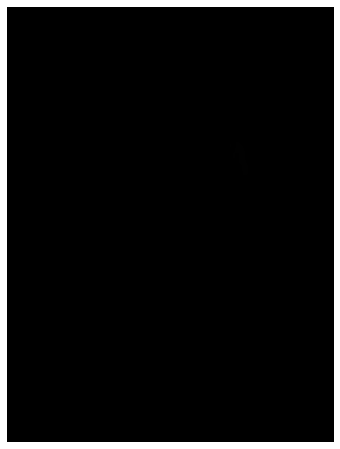

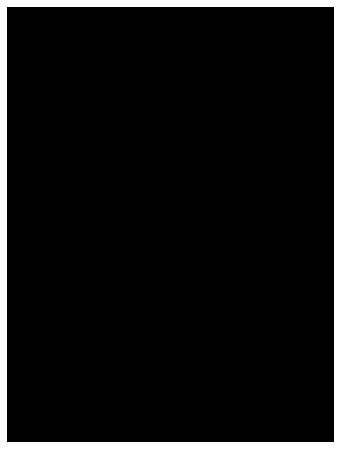

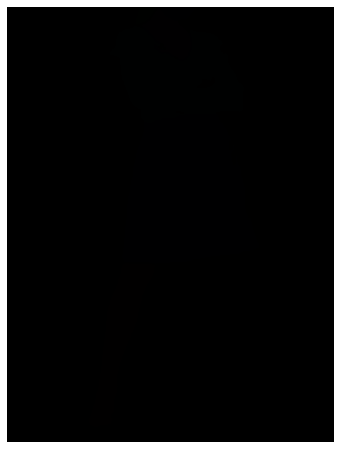

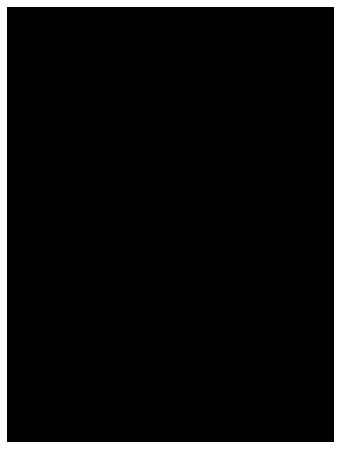

In [ ]:
def shaded_segmentation_mask(human_parsing, pose_json_test):
    mask = np.zeros_like(human_parsing)
    body_parts = [22, 64, 128, 192]
    for part in body_parts:
        part_mask = np.where(human_parsing == part, 1, 0)
        show(part_mask, cmap = None)
shaded_segmentation_mask(human_parsing['168762_00.png'], pose_json_test)

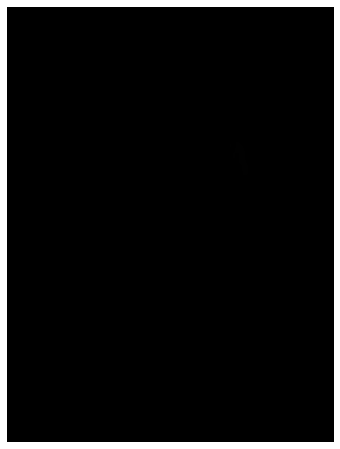

ValueError: ignored

In [ ]:
def shaded_segmentation_mask(human_parsing, pose_json_test):
    mask = np.zeros_like(human_parsing)
    body_parts = [22, 64, 128, 192]
    for part in body_parts:
        part_mask = np.where(human_parsing == part, 1, 0)
        show(part_mask)
        for (x, y) in pose_json_test:
            if x >= 0 and x < human_parsing.shape[1] and y >= 0 and y < human_parsing.shape[0]:
                if part_mask[int(y), int(x)] == 1:
                    mask[np.where(human_parsing == part)] = 1
                    break
    return mask

mask = shaded_segmentation_mask(human_parsing['168762_00.png'], pose_json_test)

In [ ]:
show(np.logical_and(human_parsing['168762_00.png'] == 22, human_parsing['168762_00.png'] == 64))

ValueError: ignored

<Figure size 1008x576 with 1 Axes>

In [ ]:
test = shaded_segmentation_mask(image['168762_00.jpg'], human_parsing['168762_00.png'], pose_json_test)
show(test, cmap= 'gray')

ValueError: ignored

In [ ]:
pose_json_test = list(zip(x[-13:], y[-13:]))

In [ ]:
pose_json_test

[(414.184, 340.53),
 (351.829, 340.551),
 (309.427, 598.319),
 (235.8, 896.071),
 (465.346, 337.705),
 (462.247, 626.72),
 (411.386, 864.817),
 (436.87, 941.286),
 (453.918, 932.792),
 (385.891, 870.418),
 (230.008, 969.691),
 (210.156, 963.988),
 (247.063, 910.171)]

In [ ]:
points = np.array([[int(x), int(y)] for x, y in pose_json_test[5:]], np.int32)
points

array([[462, 626],
       [411, 864],
       [436, 941],
       [453, 932],
       [385, 870],
       [230, 969],
       [210, 963],
       [247, 910]], dtype=int32)

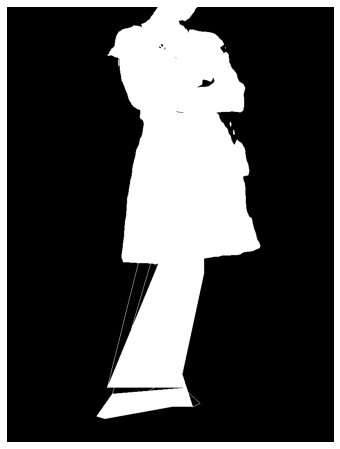

In [ ]:
points = np.array([[int(x), int(y)] for x, y in pose_json_test[:]], np.int32)
def shaded_segmentation_mask(human_parsing, image, pose_jph, pose_json):

    # Create a mask representing the body of the person
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillConvexPoly(mask, points, 1)

    # Combine the body mask with the human parsing mask
    final_mask = np.logical_or(mask, human_parsing[:, :, 2])

    return final_mask

                                    
test = shaded_segmentation_mask(human_parsing['168762_00.png'], image['168762_00.jpg'], pose_jpg['168762_00_rendered.png'], test_dic)
show(test, cmap='gray')

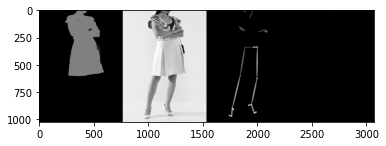

In [ ]:
imshow(np.hstack([human_parsing['168762_00.png'][:,:,2], image['168762_00.jpg'][:,:,2], pose_jpg['168762_00_rendered.png'][:,:,2], test]), cmap = 'gray')